## 1) Préparation des données de Chargement Electrique (EL)

### 1.1) Chargement des données

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df_load_2024 = pd.read_csv("Belgium - Total Load - Day Ahead _ Actual_202401010000-202501010000.csv")
df_load_31_12_2023 = pd.read_csv("Total Load - Day Ahead _ Actual_202312310000-202401010000.csv")
df_load = pd.concat([df_load_31_12_2023, df_load_2024], ignore_index=True)
df_load["Time (CET/CEST)"] = df_load["Time (CET/CEST)"].str.split(" - ").str[0]
df_load = df_load.drop(columns=["Day-ahead Total Load Forecast [MW] - BZN|BE"])
df_load["Time (CET/CEST)"] = pd.to_datetime(df_load["Time (CET/CEST)"], format="%d.%m.%Y %H:%M")

### 1.2) Ajustement avec les changement horraires (été et hiver)

A cause du changement horraire ayant lieu au mois de mars nous avons des valeurs manquantes sur une plage de 1 heure car passage à +1H (soit 4 valeurs manquantes).

On va y remédier via une loi uniforme sur l'intervalle concerné

In [2]:

# Détection des indices avec des valeurs manquantes
na_indices = df_load[df_load["Actual Total Load [MW] - BZN|BE"].isna()].index

if not na_indices.empty:
    print(f"Valeurs manquantes détectées à ces indices : {list(na_indices)}")
    
    # Définir les 4 valeurs possibles uniformes entre 7546 et 7604
    replacement_values = np.linspace(7546, 7604, 4)

    for i in na_indices:
        replacement = np.random.choice(replacement_values)
        print(f"Remplacement à l’indice {i} par {replacement:.2f}")
        df_load.at[i, "Actual Total Load [MW] - BZN|BE"] = replacement
else:
    print("Aucune valeur manquante détectée.")

Valeurs manquantes détectées à ces indices : [8744, 8745, 8746, 8747]
Remplacement à l’indice 8744 par 7604.00
Remplacement à l’indice 8745 par 7584.67
Remplacement à l’indice 8746 par 7546.00
Remplacement à l’indice 8747 par 7565.33


Idem pour le pasage à l'heure d'hiver qui fait -1H ce qui fait que les valeurs sont dupliqués sur une plage horraire (on va supprimer les doublons)

In [3]:
df_load.shape

(35236, 2)

In [ ]:
df_load = df_load[~df_load["Time (CET/CEST)"].duplicated(keep='first')]
df_load = df_load.reset_index(drop=True)
print(f"Nombre de lignes après suppression des doublons : {len(df_load)}")

Nombre de lignes après suppression des doublons : 35232


In [5]:
df_load.head()

,Time (CET/CEST),Actual Total Load [MW] - BZN|BE
0,2023-12-31 00:00:00,7484.0
1,2023-12-31 00:15:00,7354.0
2,2023-12-31 00:30:00,7254.0
3,2023-12-31 00:45:00,7132.0
4,2023-12-31 01:00:00,7035.0


### 1.3) Tronquer les données

In [ ]:
# Tronquer pour avoir df_load_trunc : de 1 Janv 00:00 à 31 Décembre 2024 22:45

start_date = pd.Timestamp("2024-01-01 00:00")
end_date = pd.Timestamp("2024-12-31 22:45")

df_load_trunc = df_load[(df_load["Time (CET/CEST)"] >= start_date) & (df_load["Time (CET/CEST)"] <= end_date)].reset_index(drop=True)
df_load_trunc.head()

,Time (CET/CEST),Actual Total Load [MW] - BZN|BE
0,2024-01-01 00:00:00,7521.0
1,2024-01-01 00:15:00,7456.0
2,2024-01-01 00:30:00,7425.0
3,2024-01-01 00:45:00,7344.0
4,2024-01-01 01:00:00,7335.0


### 1.4) Transposer

Afin d'avoir un format avec chaque ligne correspondant à la série temporelle d'une variable

In [7]:
df_load = df_load.T
df_load_trunc = df_load_trunc.T

In [ ]:
quarter_diff = []
two_hours_diff = []
avg_last_hours = []
one_hour_diff = []
last_day = []
one_hour_ahead = []


for k in range(df_load_trunc.shape[1]):
    current_trunc = df_load_trunc[k]["Actual Total Load [MW] - BZN|BE"]
    df_load_pos = 96+k
    last_quarter = df_load[df_load_pos-1]["Actual Total Load [MW] - BZN|BE"]
    last_two_hours = df_load[df_load_pos-8]["Actual Total Load [MW] - BZN|BE"]
    last_hour = df_load[df_load_pos-4]["Actual Total Load [MW] - BZN|BE"]
    avg_last_hour = np.mean([df_load[df_load_pos-i]["Actual Total Load [MW] - BZN|BE"] for i in range(4)])

    quarter_diff.append(current_trunc - last_quarter)
    two_hours_diff.append(current_trunc - last_two_hours)
    one_hour_diff.append(current_trunc - last_hour)
    avg_last_hours.append(avg_last_hour)
    last_day.append(df_load[df_load_pos-96]["Actual Total Load [MW] - BZN|BE"])
    one_hour_ahead.append(df_load[df_load_pos+4]["Actual Total Load [MW] - BZN|BE"])

In [9]:
df_load_trunc.head()

,0,1,2,3,4,5,6,7,8,9,...,35122,35123,35124,35125,35126,35127,35128,35129,35130,35131
Time (CET/CEST),2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 20:30:00,2024-12-31 20:45:00,2024-12-31 21:00:00,2024-12-31 21:15:00,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00
Actual Total Load [MW] - BZN|BE,7521.0,7456.0,7425.0,7344.0,7335.0,7265.0,7248.0,7202.0,7143.0,7066.0,...,9200.0,9128.0,8975.0,8876.0,8852.0,8783.0,8841.0,8852.0,8891.0,8862.0


### 1.5) Ajouter les variables de mesures précédentes

In [10]:
# Créer un DataFrame avec les nouvelles lignes
new_data = pd.DataFrame({
    "quarter_diff": quarter_diff,
    "two_hours_diff": two_hours_diff,
    "avg_last_hours": avg_last_hours,
    "one_hour_diff": one_hour_diff,
    "last_day": last_day,
    "one_hour_ahead": one_hour_ahead
})

# Transposer ce DataFrame pour correspondre à la structure de df_load_trunc
new_data = new_data.T

# Ajouter ces nouvelles lignes à df_load_trunc
df_load_trunc_full = pd.concat([df_load_trunc, new_data], ignore_index=False)

# Vérifier le résultat
df_load_trunc_full.head(11)


,0,1,2,3,4,5,6,7,8,9,...,35122,35123,35124,35125,35126,35127,35128,35129,35130,35131
Time (CET/CEST),2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 20:30:00,2024-12-31 20:45:00,2024-12-31 21:00:00,2024-12-31 21:15:00,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00
Actual Total Load [MW] - BZN|BE,7521.0,7456.0,7425.0,7344.0,7335.0,7265.0,7248.0,7202.0,7143.0,7066.0,...,9200.0,9128.0,8975.0,8876.0,8852.0,8783.0,8841.0,8852.0,8891.0,8862.0
quarter_diff,-19.0,-65.0,-31.0,-81.0,-9.0,-70.0,-17.0,-46.0,-59.0,-77.0,...,-67.0,-72.0,-153.0,-99.0,-24.0,-69.0,58.0,11.0,39.0,-29.0
two_hours_diff,-394.0,-469.0,-419.0,-450.0,-527.0,-493.0,-391.0,-338.0,-378.0,-390.0,...,-811.0,-821.0,-760.0,-805.0,-761.0,-745.0,-501.0,-415.0,-309.0,-266.0
avg_last_hours,7614.5,7539.0,7485.5,7436.5,7390.0,7342.25,7298.0,7262.5,7214.5,7164.75,...,9334.25,9234.25,9142.5,9044.75,8957.75,8871.5,8838.0,8832.0,8841.75,8861.5
one_hour_diff,-341.0,-302.0,-214.0,-196.0,-186.0,-191.0,-177.0,-142.0,-192.0,-199.0,...,-413.0,-400.0,-367.0,-391.0,-348.0,-345.0,-134.0,-24.0,39.0,79.0
last_day,7484.0,7354.0,7254.0,7132.0,7035.0,6927.0,6852.0,6747.0,6621.0,6633.0,...,9744.0,9663.0,9605.0,9504.0,9368.0,9234.0,9123.0,9102.0,9172.0,9180.0
one_hour_ahead,7335.0,7265.0,7248.0,7202.0,7143.0,7066.0,7001.0,6922.0,6878.0,6835.0,...,8852.0,8783.0,8841.0,8852.0,8891.0,8862.0,8857.0,8773.0,8696.0,8592.0


## 2) Préparation données climatiques

### 2.1) Chargement des données météo

Nous allons utiliser les 3 variables climatiques suivantes : 

**Température**

- `TEMP_DRY_SHELTER_AVG`: Température sèche moyenne (en °C) sous un abri fermé au cours des 10 dernières minutes

**Vent**

- `WIND_SPEED_AVG_30M` : Vitesse moyenne du vent (en m/s) à 30m d'altitude au cours des 10 dernières minutes

**Humidité relative**

- `HUMIDITY_REL_SHELTER_AVG`: Humidité relative moyenne dans l'abri en bois au cours des 10 dernières minutes

In [11]:
import os
import json

def data_meteo(path): 
    """Création d'un dataframe météo qui provient de la concaténation
    de plusieurs fichiers .csv dans un dossier"""
    record = os.listdir(path)
    L = []
    for i in record:
        L.append(pd.read_csv(path + '/' + i))

    return pd.concat(L)

df_weather = data_meteo('Donnees meteo')

def filtration_data_meteo(df, col): 
    return df[col].copy()

variable = ['code', 'timestamp','temp_dry_shelter_avg', 'humidity_rel_shelter_avg', 'wind_speed_avg_30m']

df_weather = filtration_data_meteo(df_weather, variable)



### 2.2) Choix du site de mesure

Les données ont été mesuré sur 13 sites différents à travers la Belgique, on choisira le site permettant d'avoir les meilleures mesures

In [12]:
df_weather.groupby('code').count()

,timestamp,temp_dry_shelter_avg,humidity_rel_shelter_avg,wind_speed_avg_30m
code,,,,
6414,52704,52704,52704,0
6418,52704,52703,52703,0
6434,52704,52704,52704,52702
6438,52704,52704,52704,0
6439,52704,52704,52704,0
6447,52704,52702,52702,49956
6455,52704,48240,52704,0
6459,52704,52704,52704,0
6464,52704,52704,52704,0


On remarque que les données de la variable `WIND_SPEED_AVG_30M` sont présentes uniquement dans les codes **6434**, **6447** et **6472**.

Parmi ces sites on prendra celui ayant la meilleure répartition

In [13]:
def codes_filtration(df, codes):
    return df[df['code'].isin(codes)]


codes_nb = [6434, 6447, 6472]

df_weather = codes_filtration(df_weather, codes_nb)
df_weather.groupby('code').describe()

temp_dry_shelter_avg                                                       
                    count       mean       std       min       25%        50%   
code                                                                            
6434              52704.0  12.024807  6.153601 -5.834376  7.793116  11.942750  \
6447              52702.0  11.869972  6.355656 -6.775424  7.573523  11.768354   
6472              52704.0  10.594084  6.546623 -9.314511  6.210411  10.508727   

                           humidity_rel_shelter_avg             ...   
            75%        max                    count       mean  ...   
code                                                            ...   
6434  16.239998  33.252114                  52704.0  83.625367  ...  \
6447  16.194534  33.999270                  52702.0  83.051074  ...   
6472  14.887452  31.873061                  52704.0  80.695976  ...   

                       wind_speed_avg_30m                                      
            75%    max              count      mean       std  min       25%   
code                                                                           
6434  94.215835  100.0            52702.0  4.341297  2.253812  0.3  2.701779  \
6447  95.059464  100.0            49956.0  3.415378  1.793478  0.3  2.074427   
6472  92.392488  100.0            52704.0  4.672814  2.503970  0.3  2.818263   

                                     
           50%       75%        max  
code                                 
6434  3.980712  5.578434  18.028341  
6447  3.060607  4.389971  13.584920  
6472  4.191154  6.065664  17.857720  

[3 rows x 24 columns]

Pour simplifier les calculs, nous avons décidé de prendre les données météorologique d'un point en particulier. En remarque qu'il est plutôt préférable de prendre le code 6472 ou les données ont l'air moins déviées (par rapport à l'espérence).

In [14]:
df_weather = codes_filtration(df_weather, [6472])
df_weather = df_weather.drop(columns=["code"])
df_weather.head(10)

,timestamp,temp_dry_shelter_avg,humidity_rel_shelter_avg,wind_speed_avg_30m
8,2024-08-01T00:00:00,20.289929,76.050646,3.123536
21,2024-08-01T00:10:00,20.222202,77.260083,2.327400
34,2024-08-01T00:20:00,20.049920,78.072700,2.480000
47,2024-08-01T00:30:00,20.293457,77.681783,3.212189
60,2024-08-01T00:40:00,20.092104,76.778923,3.663304
73,2024-08-01T00:50:00,19.764699,77.080438,3.907173
86,2024-08-01T01:00:00,19.799977,78.156196,3.847296
99,2024-08-01T01:10:00,19.737450,78.391084,3.251720
112,2024-08-01T01:20:00,19.849441,78.316442,4.420491
125,2024-08-01T01:30:00,20.193984,77.890103,4.170808


### 2.3) Intégration d'intervalles de 15 minutes

Notre objectif est d'enlever la colonne code puis de retravailler ce dataframe pour qu'on puisse coincider avec les données électrique (chaque 15min). Or, ici, nous avons les données toutes les 10min. Pour transformer les données en intervalle de 15 min nous décidons de faire une moyenne entre h10 et h20 qu'on considère h15 de meme pour h45 qui sera une moyenne entre h40 et h50.

In [15]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather = df_weather.set_index('timestamp')

def custom_rounding(ts):
    minute = ts.minute
    if minute == 10 or minute == 20:
        return ts.replace(minute=15)
    elif minute == 40 or minute == 50:
        return ts.replace(minute=45)
    elif minute == 0 or minute == 30:
        return ts  # on garde tel quel
    else:
        return pd.NaT  # on ignore les autres cas si jamais

df_weather['rounded'] = df_weather.index.map(custom_rounding)
df_clean = df_weather.dropna(subset=['rounded'])  # retirer les NaT

df_resampled = df_clean.groupby('rounded').mean()
df_resampled = df_resampled.asfreq('15T')  # crée une grille régulière toutes les 15 minutes

df_weather = df_resampled.reset_index()

df_weather = df_weather.rename(columns={'rounded': 'timestamp'})
df_weather = df_weather.T

df_weather.head()

,0,1,2,3,4,5,6,7,8,9,...,35126,35127,35128,35129,35130,35131,35132,35133,35134,35135
timestamp,2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00,2024-12-31 23:00:00,2024-12-31 23:15:00,2024-12-31 23:30:00,2024-12-31 23:45:00
temp_dry_shelter_avg,6.461481,6.505177,6.379009,6.31082,6.370495,6.3488,6.390995,6.430475,6.39229,6.40926,...,1.464174,1.415156,1.350448,1.302885,1.309407,1.366891,1.465792,1.660867,1.72012,1.774516
humidity_rel_shelter_avg,74.300589,73.666562,73.263206,73.776837,73.571047,73.4108,73.657074,73.341009,73.150612,73.265104,...,97.003677,96.979429,96.985965,97.008526,97.025183,97.04901,97.07157,97.112265,97.070305,97.17299
wind_speed_avg_30m,12.132168,12.553345,11.710411,11.467995,11.236915,11.092453,11.634837,11.764474,10.508795,11.171079,...,9.239163,8.621932,8.721195,9.444955,8.551445,9.125512,9.125803,9.380136,10.409096,9.497274


On a bien maintenant des séries temporelles avec un intervalle de 15 minutes tout comme les données de chargement électrique

### 2.4) Tronquer les données

Puisqu'on veut prédire la valeur du chargement électrique dans +1h, on va tronquer pour que les données s'arrêtent à 31 décembre 2024 22h45

In [16]:
df_weather_trunc = df_weather.drop(columns=[35132+k for k in range(4)])
df_weather_trunc.head()

,0,1,2,3,4,5,6,7,8,9,...,35122,35123,35124,35125,35126,35127,35128,35129,35130,35131
timestamp,2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 20:30:00,2024-12-31 20:45:00,2024-12-31 21:00:00,2024-12-31 21:15:00,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00
temp_dry_shelter_avg,6.461481,6.505177,6.379009,6.31082,6.370495,6.3488,6.390995,6.430475,6.39229,6.40926,...,1.179146,1.199946,1.198345,1.342789,1.464174,1.415156,1.350448,1.302885,1.309407,1.366891
humidity_rel_shelter_avg,74.300589,73.666562,73.263206,73.776837,73.571047,73.4108,73.657074,73.341009,73.150612,73.265104,...,97.270614,97.128711,97.133139,97.100457,97.003677,96.979429,96.985965,97.008526,97.025183,97.04901
wind_speed_avg_30m,12.132168,12.553345,11.710411,11.467995,11.236915,11.092453,11.634837,11.764474,10.508795,11.171079,...,8.170381,8.743721,9.415307,9.62415,9.239163,8.621932,8.721195,9.444955,8.551445,9.125512


### 2.4) Ajout de variables de mesures intermédiaires 

Voici la liste des variables de mesures intermédiaires que nous allons ajouter : 

- Différence de température entre celle dans une heure et l'actuelle
- Différence d'humidité entre celle dans une heure et l'actuelle
- Différence vitesse du vent entre celle dans une heure et l'actuelle

In [17]:
temp_hour_diff = []
humidity_hour_diff = []
windSpeed_hour_diff = []

for k in range(df_weather_trunc.shape[1]):
    temp_hour_diff.append(df_weather[k+4]["temp_dry_shelter_avg"] - df_weather_trunc[k]["temp_dry_shelter_avg"])
    humidity_hour_diff.append(df_weather[k+4]["humidity_rel_shelter_avg"] - df_weather_trunc[k]["humidity_rel_shelter_avg"])
    windSpeed_hour_diff.append(df_weather[k+4]["wind_speed_avg_30m"] - df_weather_trunc[k]["wind_speed_avg_30m"])

    

In [18]:
new_variables = pd.DataFrame({
    "temp_hour_diff": temp_hour_diff,
    "humidity_hour_diff": humidity_hour_diff,
    "windSpeed_hour_diff": windSpeed_hour_diff
})

# Transposer ce DataFrame pour correspondre à la structure de df_load_trunc
new_variables = new_variables.T

# Ajouter ces nouvelles lignes à df_load_trunc
df_weather_trunc_full = pd.concat([df_weather_trunc, new_variables], ignore_index=False)

# Vérifier le résultat
df_weather_trunc_full.head(10)

,0,1,2,3,4,5,6,7,8,9,...,35122,35123,35124,35125,35126,35127,35128,35129,35130,35131
timestamp,2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 20:30:00,2024-12-31 20:45:00,2024-12-31 21:00:00,2024-12-31 21:15:00,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00
temp_dry_shelter_avg,6.461481,6.505177,6.379009,6.31082,6.370495,6.3488,6.390995,6.430475,6.39229,6.40926,...,1.179146,1.199946,1.198345,1.342789,1.464174,1.415156,1.350448,1.302885,1.309407,1.366891
humidity_rel_shelter_avg,74.300589,73.666562,73.263206,73.776837,73.571047,73.4108,73.657074,73.341009,73.150612,73.265104,...,97.270614,97.128711,97.133139,97.100457,97.003677,96.979429,96.985965,97.008526,97.025183,97.04901
wind_speed_avg_30m,12.132168,12.553345,11.710411,11.467995,11.236915,11.092453,11.634837,11.764474,10.508795,11.171079,...,8.170381,8.743721,9.415307,9.62415,9.239163,8.621932,8.721195,9.444955,8.551445,9.125512
temp_hour_diff,-0.090986,-0.156377,0.011986,0.119655,0.021795,0.06046,0.003254,-0.056287,-0.057357,-0.167423,...,0.285028,0.215211,0.152103,-0.039905,-0.154767,-0.048266,0.115344,0.357983,0.410713,0.407625
humidity_hour_diff,-0.729542,-0.255762,0.393868,-0.435828,-0.420435,-0.145697,-0.478208,-0.33968,-0.242478,-0.457756,...,-0.266937,-0.149282,-0.147174,-0.091931,0.021506,0.069581,0.085605,0.103739,0.045122,0.12398
windSpeed_hour_diff,-0.895253,-1.460891,-0.075574,0.29648,-0.72812,0.078625,-0.142717,-0.027322,1.220218,0.044036,...,1.068782,-0.121789,-0.694112,-0.179195,-0.687718,0.50358,0.404608,-0.064819,1.857651,0.371762


### 2.5) Sélection de variables et transposition des données

On n'utilise pas toutes les variables, car elles sont surement corrélés, le différence avec des mesures précédentes suffisent 

(tout comme le papier de recherche le précise)

In [ ]:
df_select = df_weather_trunc_full.T.drop(columns=["temp_dry_shelter_avg", "humidity_rel_shelter_avg", "wind_speed_avg_30m"])
df_weather_trunc_full = df_select.T
df_weather_trunc_full.head()

,0,1,2,3,4,5,6,7,8,9,...,35122,35123,35124,35125,35126,35127,35128,35129,35130,35131
timestamp,2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 20:30:00,2024-12-31 20:45:00,2024-12-31 21:00:00,2024-12-31 21:15:00,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00
temp_hour_diff,-0.090986,-0.156377,0.011986,0.119655,0.021795,0.06046,0.003254,-0.056287,-0.057357,-0.167423,...,0.285028,0.215211,0.152103,-0.039905,-0.154767,-0.048266,0.115344,0.357983,0.410713,0.407625
humidity_hour_diff,-0.729542,-0.255762,0.393868,-0.435828,-0.420435,-0.145697,-0.478208,-0.33968,-0.242478,-0.457756,...,-0.266937,-0.149282,-0.147174,-0.091931,0.021506,0.069581,0.085605,0.103739,0.045122,0.12398
windSpeed_hour_diff,-0.895253,-1.460891,-0.075574,0.29648,-0.72812,0.078625,-0.142717,-0.027322,1.220218,0.044036,...,1.068782,-0.121789,-0.694112,-0.179195,-0.687718,0.50358,0.404608,-0.064819,1.857651,0.371762


## 3) Jointure des données EL avec les données climatiques 

In [20]:
df_full_trunc = df_load_trunc_full.T.join(df_weather_trunc_full.T, how="outer")

In [21]:
df_full_trunc.head()

,Time (CET/CEST),Actual Total Load [MW] - BZN|BE,quarter_diff,two_hours_diff,avg_last_hours,one_hour_diff,last_day,one_hour_ahead,timestamp,temp_hour_diff,humidity_hour_diff,windSpeed_hour_diff
0,2024-01-01 00:00:00,7521.0,-19.0,-394.0,7614.5,-341.0,7484.0,7335.0,2024-01-01 00:00:00,-0.090986,-0.729542,-0.895253
1,2024-01-01 00:15:00,7456.0,-65.0,-469.0,7539.0,-302.0,7354.0,7265.0,2024-01-01 00:15:00,-0.156377,-0.255762,-1.460891
2,2024-01-01 00:30:00,7425.0,-31.0,-419.0,7485.5,-214.0,7254.0,7248.0,2024-01-01 00:30:00,0.011986,0.393868,-0.075574
3,2024-01-01 00:45:00,7344.0,-81.0,-450.0,7436.5,-196.0,7132.0,7202.0,2024-01-01 00:45:00,0.119655,-0.435828,0.29648
4,2024-01-01 01:00:00,7335.0,-9.0,-527.0,7390.0,-186.0,7035.0,7143.0,2024-01-01 01:00:00,0.021795,-0.420435,-0.72812


In [22]:
df = df_full_trunc
df = df.drop(columns=['timestamp'])  # Supprimer la colonne timestamp

# Réordonner les colonnes dans l'ordre souhaité
ordered_columns = [
    'Time (CET/CEST)', 'temp_hour_diff', 'humidity_hour_diff', 'windSpeed_hour_diff',
    'Actual Total Load [MW] - BZN|BE', 'quarter_diff', 'two_hours_diff', 'avg_last_hours',
    'one_hour_diff', 'last_day', 'one_hour_ahead'
]

df = df[ordered_columns]

In [23]:
df = df.T
df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,35122,35123,35124,35125,35126,35127,35128,35129,35130,35131
Time (CET/CEST),2024-01-01 00:00:00,2024-01-01 00:15:00,2024-01-01 00:30:00,2024-01-01 00:45:00,2024-01-01 01:00:00,2024-01-01 01:15:00,2024-01-01 01:30:00,2024-01-01 01:45:00,2024-01-01 02:00:00,2024-01-01 02:15:00,...,2024-12-31 20:30:00,2024-12-31 20:45:00,2024-12-31 21:00:00,2024-12-31 21:15:00,2024-12-31 21:30:00,2024-12-31 21:45:00,2024-12-31 22:00:00,2024-12-31 22:15:00,2024-12-31 22:30:00,2024-12-31 22:45:00
temp_hour_diff,-0.090986,-0.156377,0.011986,0.119655,0.021795,0.06046,0.003254,-0.056287,-0.057357,-0.167423,...,0.285028,0.215211,0.152103,-0.039905,-0.154767,-0.048266,0.115344,0.357983,0.410713,0.407625
humidity_hour_diff,-0.729542,-0.255762,0.393868,-0.435828,-0.420435,-0.145697,-0.478208,-0.33968,-0.242478,-0.457756,...,-0.266937,-0.149282,-0.147174,-0.091931,0.021506,0.069581,0.085605,0.103739,0.045122,0.12398
windSpeed_hour_diff,-0.895253,-1.460891,-0.075574,0.29648,-0.72812,0.078625,-0.142717,-0.027322,1.220218,0.044036,...,1.068782,-0.121789,-0.694112,-0.179195,-0.687718,0.50358,0.404608,-0.064819,1.857651,0.371762
Actual Total Load [MW] - BZN|BE,7521.0,7456.0,7425.0,7344.0,7335.0,7265.0,7248.0,7202.0,7143.0,7066.0,...,9200.0,9128.0,8975.0,8876.0,8852.0,8783.0,8841.0,8852.0,8891.0,8862.0
quarter_diff,-19.0,-65.0,-31.0,-81.0,-9.0,-70.0,-17.0,-46.0,-59.0,-77.0,...,-67.0,-72.0,-153.0,-99.0,-24.0,-69.0,58.0,11.0,39.0,-29.0
two_hours_diff,-394.0,-469.0,-419.0,-450.0,-527.0,-493.0,-391.0,-338.0,-378.0,-390.0,...,-811.0,-821.0,-760.0,-805.0,-761.0,-745.0,-501.0,-415.0,-309.0,-266.0
avg_last_hours,7614.5,7539.0,7485.5,7436.5,7390.0,7342.25,7298.0,7262.5,7214.5,7164.75,...,9334.25,9234.25,9142.5,9044.75,8957.75,8871.5,8838.0,8832.0,8841.75,8861.5
one_hour_diff,-341.0,-302.0,-214.0,-196.0,-186.0,-191.0,-177.0,-142.0,-192.0,-199.0,...,-413.0,-400.0,-367.0,-391.0,-348.0,-345.0,-134.0,-24.0,39.0,79.0
last_day,7484.0,7354.0,7254.0,7132.0,7035.0,6927.0,6852.0,6747.0,6621.0,6633.0,...,9744.0,9663.0,9605.0,9504.0,9368.0,9234.0,9123.0,9102.0,9172.0,9180.0


### 3.1) Affichage d'un échantillon des 2 premiers jours de l'année du Chargement électrique

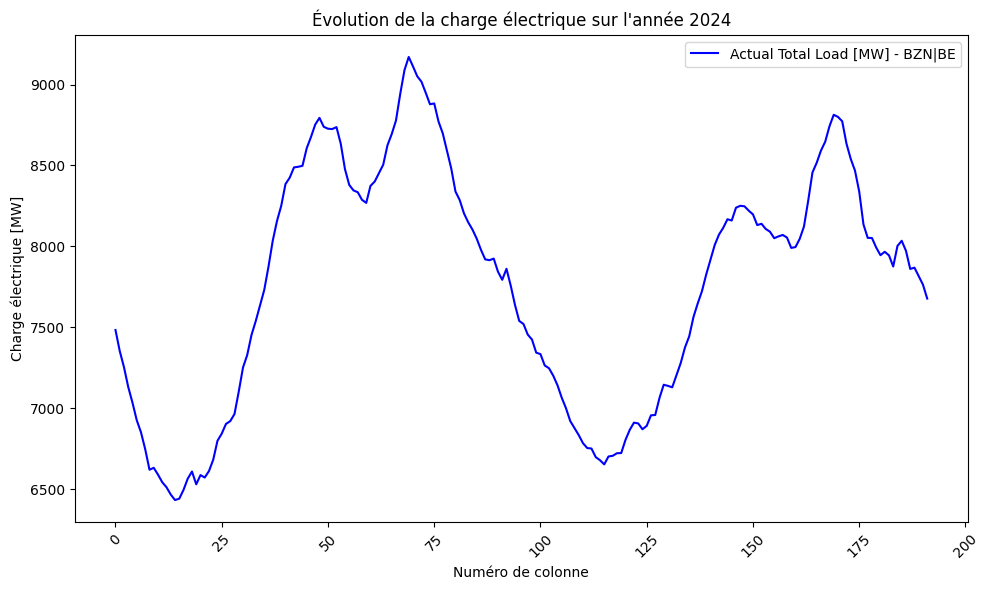

In [24]:
import matplotlib.pyplot as plt
# Pour 2 jours 4*24*2
nb_points = 192
# Tracer la 10ème ligne avec les indices des colonnes comme abscisses
plt.figure(figsize=(10, 6))
plt.plot(df.columns[:nb_points], df.iloc[9][:nb_points], label="Actual Total Load [MW] - BZN|BE", color='blue')

# Ajouter un titre et des labels
plt.title("Évolution de la charge électrique sur l'année 2024")
plt.xlabel("Numéro de colonne")
plt.ylabel("Charge électrique [MW]")
plt.xticks(rotation=45)  # Optionnel pour mieux voir les labels si nécessaire
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()


## 4) Entrainement pour la sparsité

#### Pour l'entrainement on va utiliser les données allant de Septembre à Novembre 2024 ce qui fait :  
$ 4 \times 24 \times 30 + 4 \times 24 \times 31 + 4 \times 24 \times 30 = $ 8736 points. 
#### Et le test se fera sur les données de Janvier à Août 2024. 

#### Il s'agit de la première approche décrite dans notre rapport. Il suffit de changer X_train et X_test, puis d'enlever la normalisation pour se mettre dans la config de l'approche 2.

### 4.1) Préparation données d'entrainement et Test

In [25]:
import numpy as np
import pandas as pd
from sklearn.decomposition import DictionaryLearning
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Début de votre code : prétraitement des données
X = df.T.drop(columns=["Time (CET/CEST)"]).T  # Retirer la colonne du temps si présente
X = X.values
"""
Chaque ligne de X est une série temporelle il y a en tout 10 lignes dans X.

Le but dans la suite sera d'apprendre un dictionnaire D qui permettra de reconstruire X.
L'apprentissage de D se fera sur une partie de X => X_train
"""
# La taille de l'entrainement 
N =  8736
X_train = X[:, 23424:32160]
X_test = X[:,:23424]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.T)
X_train_scaled = X_train_scaled.T
X_test_scaled = scaler.transform(X_test.T)
X_test_scaled = X_test_scaled.T

"""
Pour apprendre le dictionnaire D qui reconstruit X_train 
il faut résoudre un problème de LASSO avec la méthode de LARS-LASSO

minimiser 0.5||X_train - DA||² + lambda||A||

D est de dimension 10*N
A est une matrice d’activation apprise de dimension K × N
On choisit K>10
"""
K = 12

"""  
Maintenant il faut résoudre ce problème de Lasso avec la méthode LARS-LASSO
Trouver D et A qui reconstruisent X_train
"""

'  \nMaintenant il faut résoudre ce problème de Lasso avec la méthode LARS-LASSO\nTrouver D et A qui reconstruisent X_train\n'

### 4.2) Résolution du problème avec le dictionnaire D et la matrice de coefficients A

In [26]:
# Apprentissage du dictionnaire avec la méthode de Dictionary Learning
dict_learn = DictionaryLearning(n_components=K, alpha=1, max_iter=100, n_jobs=-1, random_state=0)
X_train_dict = dict_learn.fit_transform(X_train_scaled.T).T  # Transposer pour que chaque ligne représente une observation

# Extraire le dictionnaire D appris
D = dict_learn.components_.T  # Dictionnaire D, de taille (10, K)

# Appliquer Lasso pour apprendre les coefficients A
lasso = LassoLars(alpha=0.1, max_iter= 100)
A = np.zeros((K, N))  # Matrice des coefficients A de taille (K, N)
for i in range(N):
    lasso.fit(D, X_train_scaled[:, i])  # Apprendre A pour chaque série temporelle dans X_train
    A[:, i] = lasso.coef_  # Stocker les coefficients

### 4.3) Reconstruction du signal d'entrée (l'entrainement de Septembre à Novembre 2024) avec D et A

In [27]:
X_train_reconstructed = np.dot(D, A)

In [28]:
print(X_train_scaled.shape)

(10, 8736)


Visualisation sur les 2 premiers jours reconstruits

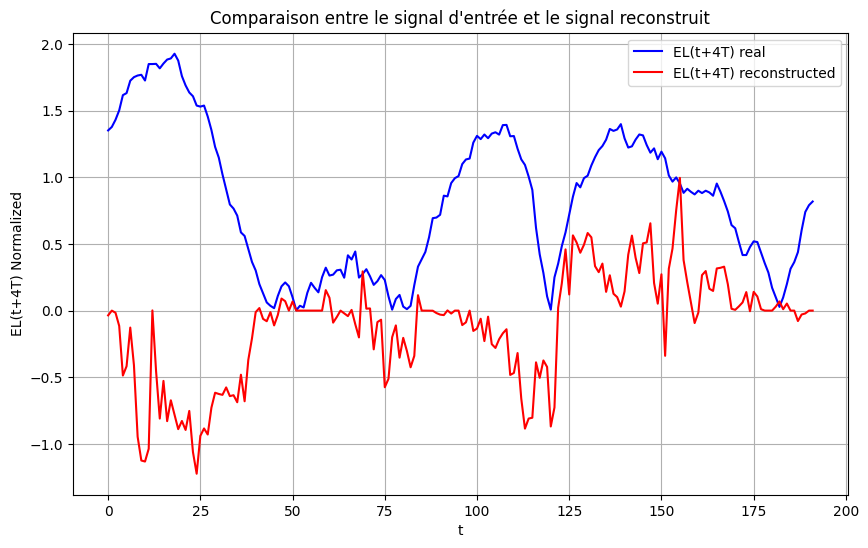

In [29]:
nb_points = 192
indexes = [k for k in range(nb_points)]#X_train.shape[1])]

plt.figure(figsize=(10, 6))
plt.plot(indexes, np.abs(X_train_scaled[9][:nb_points]), label="EL(t+4T) real", color='blue')
plt.plot(indexes, X_train_reconstructed[9][:nb_points], label="EL(t+4T) reconstructed", color='red')
plt.xlabel('t')
plt.ylabel('EL(t+4T) Normalized')
plt.legend()
plt.title("Comparaison entre le signal d'entrée et le signal reconstruit")
plt.grid(True)
plt.savefig("reconstructed_train_second_approach.pdf", format="pdf")
plt.show()

## 5) Méthode de prédiction du chargement au bout d'une heure grâce au vecteur $\alpha_{tr}$

### Maintenant qu'on a trouvé le dictionnaire D, l'idée c'est de pouvoir trouvé le vecteur alpha qui résout le problème de LASSO suivant : 


$$\alpha_{tr} = \arg\min_{\alpha_{tr}} {{\|q_{tr} - D_{tr}\alpha_{tr}\|}_2}^2 + \lambda \|\alpha_{tr}\|_1 $$


Il faudra le faire via une fonction qui étant donné un vecteur q de dimension disons d avec D matrice donnée en paramètre, on puisse nous retourner le vecteur alpha de dimension d qui résout le problème de LASSO par la méthode LARS-LASSO.

In [31]:
from sklearn.linear_model import LassoLars

def sparse_vector_alpha(q, D, lambda_=0.1):
    """
    Résout le problème de LASSO suivant pour un vecteur q :
        alpha = argmin ||q - D @ alpha||^2 + lambda * ||alpha||_1

    Args:
        q (np.ndarray): vecteur de taille (d,)
        D (np.ndarray): dictionnaire de taille (d, K)
        lambda_ (float): paramètre de régularisation

    Returns:
        alpha (np.ndarray): vecteur alpha de taille (K,)
    """
    model = LassoLars(alpha=lambda_, fit_intercept=False, normalize=False)
    model.fit(D, q)
    return model.coef_

Testons la fonction sur une entrée de signal, soit par exemple la première colonne (première mesure de l'entrainement)

In [ ]:
# Soit q la première colonne de X_train

q_test = X_train_scaled[:,0]

# Je veux alpha_tr : 

alpha_test = sparse_vector_alpha(q_test, D, lambda_=0.1)

print(alpha_test)

[-0.98608036 -0.52745625  0.49311147  0.          0.42689379  1.07050134
  0.          0.          0.          0.          0.          0.        ]


L'output ci-dessus est le vecteur de coefficients $\alpha_{tr}$ correspondant à $D_{tr}$ pour retrouver le signal d'entrée

## 6) Prédiction sur les données tests

On parcourt les données Tests en prennant les vecteurs de taille d-1 puis j'obtiens alpha de taille d-1 et à la fin avec le produit matriciel, entre D et alpha_tronqué

In [33]:
Load_forecast = []
D_tr = D[:-1,:]
for k in range(X_test_scaled.shape[1]):
    q_tr = X_test_scaled[:-1,k]
    alpha_tr = sparse_vector_alpha(q_tr, D_tr, lambda_=0.1)
    forecast = np.dot(D, alpha_tr)
    Load_forecast.append(forecast[-1])

In [34]:
Valid_Test_Load = X_test_scaled[-1,:]

## 7) Evaluation de la prédiction

### 7.1) Mean Squared Error (MSE)

In [ ]:
## Intervalle avec la plus grande erreur absolue 
worst_abs_error = np.argmax(abs(Valid_Test_Load - Load_forecast))
print(worst_abs_error)

2756


In [ ]:
## Affichons la MSE
MSE = np.mean((Valid_Test_Load - Load_forecast) ** 2)
print(MSE)

0.22821560352171455


Affichons la prédiction sur l'intervalle centrée en la plus grande erreur absolue.

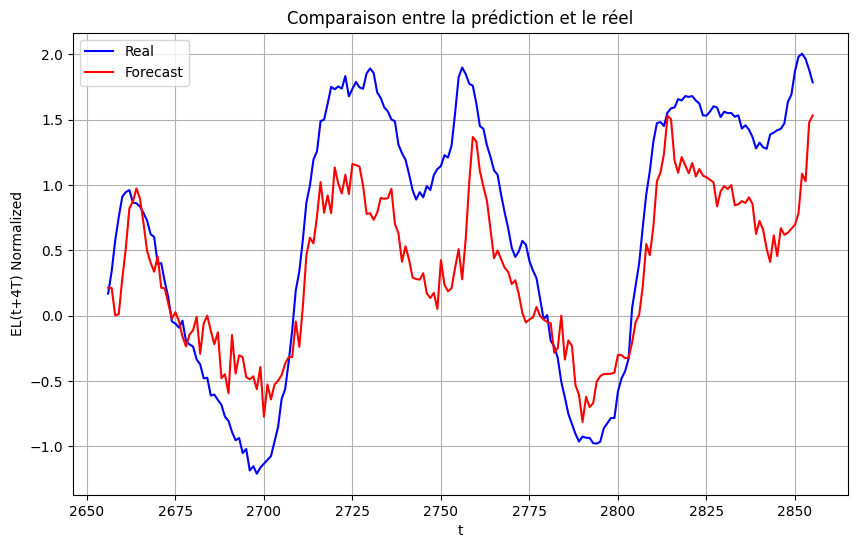

In [38]:
left = worst_abs_error-100
right = worst_abs_error+100
indexes = [k for k in range(left, right)]
plt.figure(figsize=(10, 6))
plt.plot(indexes, Valid_Test_Load[left:right], label="Real", color='blue')
plt.plot(indexes, Load_forecast[left:right], label="Forecast", color='red')
plt.xlabel('t')
plt.ylabel('EL(t+4T) Normalized')
plt.legend()
plt.title('Comparaison entre la prédiction et le réel')
plt.grid(True)
plt.savefig("Predicted_second_approach.pdf", format="pdf")
plt.show()

### 7.2) R² Score

In [39]:
from sklearn.metrics import r2_score, mean_absolute_error

r2_score(Valid_Test_Load, Load_forecast)

0.7804445182118619

### 7.3) Mean Absolute Error (MAE)

In [40]:
mae = mean_absolute_error(Valid_Test_Load, Load_forecast)
print(mae)

0.4054264968241086
